In this notebook we'll extend the optimization from 1D_Airplane to include the z-axis, allowing our plane to do simple acrobatics and hopefully even extending our optimization to include takeoff and landing.

This involves a slightly more involved version of the equations of motion, which we'll take from Anderson *Aircraft Performance and Design*. 

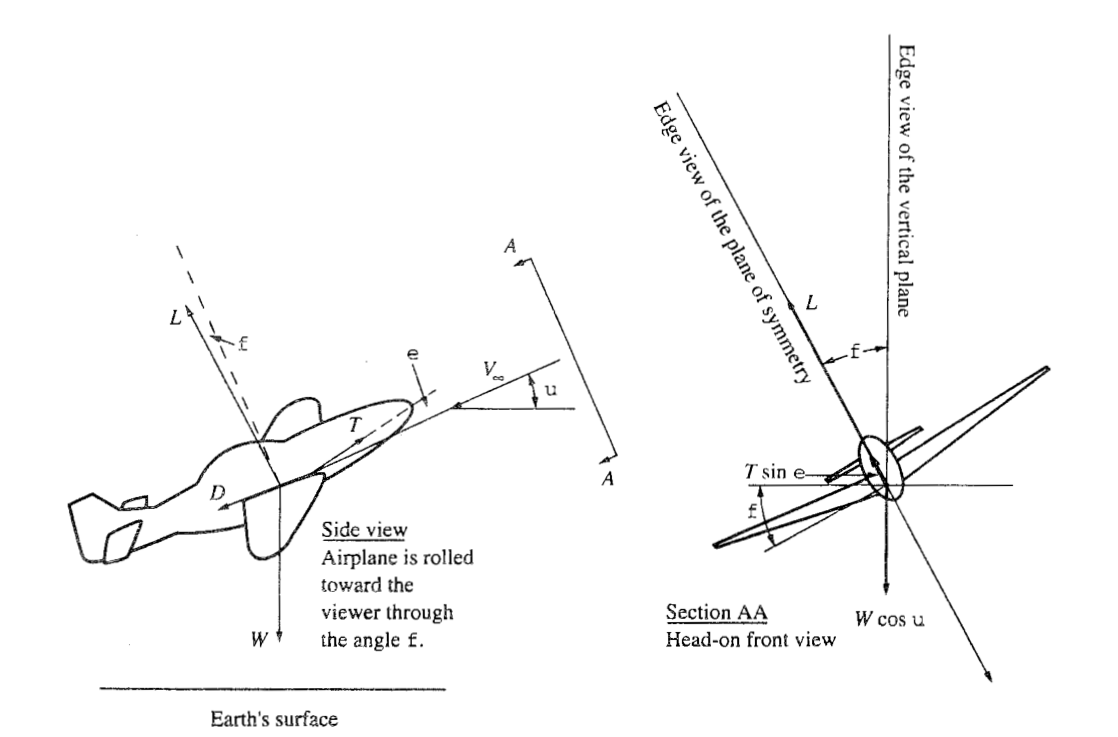

Here we have an image of the forces acting on the airplane. The airplane is rolled through an angle `f` = $\phi$, and the flight path makes an angle `u` = $\theta$ with the horizontal plane. The roll angle $\phi$ contributes to turns in the horizontal plane and the azimuthal angle $\theta$ contributes to the climb and descent of the airplane. We will assume that the angle of inclination of the thrust vector with respect to the velocity is `e` = $\epsilon = 0$

The simplest equation of motion is parallel to the velocity of the airplane $V_\infty$. Thrust pulls it forwards, drag pulls it back, and weight pulls back when climbing and forward when descending.

$$
\frac{d V_\infty}{dt} = T - D - W\sin\theta
$$

Our equations in the horizontal plane are similar to the equations for steady level flight, except that the horizontal speed $V_H$ is reduced according to the climb angle. We will extract $1/r_H = \kappa$ from the spline representing our path ($\kappa$ = `spline.curvature(xi)`). The horizontal equation is

$$
\frac{m (V_\infty cos\theta)^2 }{r_H} = L \sin\phi
$$

In the vertical plane, we have a similar situation. Anderson gives the equations of motion in the vertical direction (with $\epsilon = 0$) as

$$
m \frac{V_\infty^2}{r_V} = L \cos \phi - W\cos \theta
$$

We want to leverage the properties of these equations of motion, and the fact that our horizontal path $\gamma(\xi)$ is already known, to eliminate as many state variables as possible.


We'll now need to keep track of more state variables:

- Time $t$
- Total speed $V_\infty$
- Vertical height $z$
- Azimuthal angle $\theta$

and we have one more control input

- Thrust $T$
- Pitch rate $\dot\theta$

(A more realistic model would model the tail of the plane, and then get an expression for $\ddot{theta}$ in terms of the elevator deflection $\delta_e$. That would be one of the next steps with this model.)

Again, we can make use of the differential flatness (algebraic manipulations) to close the equations of motion under these four variables. Here's how we'll do it:

$$
\dot{\mathbf x} = \frac{d}{dt} \begin{bmatrix} t \\ V_\infty \\ z \\ \theta \end{bmatrix}
$$

Each component:

$$
\begin{align}
\frac{dt}{dt} &= 1 \\
\frac{dV_\infty}{dt} &= {T - D - W\sin\theta \over m} \\
\frac{dz}{dt} &= V_\infty \cos \theta \\
\frac{d\theta}{dt} &= {V_\infty \over r_V} = {L \cos \phi - W \cos \theta \over m V_\infty} \\
&\textbf{Algebraic closure:} \\
L \cos \phi &= \sqrt{ L^2 - L^2 \sin^2 \phi  } = \sqrt{ L^2 - \left(
    {m (V_\infty \cos \theta)^2 \over r_H}
\right)^2} \\
L^2 &= \left(
    { m (V_\infty \cos \theta)^2 \over r_H }
\right)^2 + \left(
    {m V_\infty^2 \over r_V} + W \cos \theta
\right)^2 \\
\frac{1}{r_V} &= \frac{d\theta}{dt} \frac{1}{V_\infty}
\end{align}
$$

In [ ]:
class Airplane2D:
    def __init__(self,
                 spline,
                 S, 
                 CD0,
                 K,
                 m,
                 rho=1.23,
                 g = 9.81,
                ):
        self.spline = spline  #what object is this meant to be
        self.S = S            # what is this meant to be 
        self.CD0 = CD0
        self.K = K
        self.m = m
        self.rho = rho
        self.g = g
        self.W = m * g

    def from_state(state):
        t = state[0]
        V = state[1]
        z = state[2]
        th = state[3]
        return t, V, z, th
        
    def from_ctrl(ctrl):
        T = ctrl[0]
        dth = ctrl[1]
        return T, dth
    
    def curvature(self, xi):
        return self.spline.curvature(xi)

    def sigma(self, xi):
        return np.linalg.norm(self.spline.derivative(xi))

    def q(self, state):
        _, V, _, _ = self.from_state(state)
        return 0.5 * self.rho * V**2

    def lift_components(self, xi, state, ctrl):
        _, V, _, th = self.from_state(state)
        _, dth = self.from_ctrl(ctrl)
        k_H = self.curvature(xi)
        L_H = m * (V * np.cos(th))**2 * k_H
        k_V = dth / V
        L_V = m * V**2 * k_V + self.W * np.cos(th)
        return L_H, L_V
    
    def lift(self, xi, state, ctrl):
        L_H, L_V = self.lift_components(xi, state, ctrl)
        return (L_H**2 + L_V**2)**0.5

    def drag(self, xi, state, ctrl):
        return (self.q(state))*(self.CD0 + self.K * (self.lift(xi, state, ctrl)**2 / self.q(state)**2))

        # seperate function for lift coeff
    def bank_angle(self, xi, state, ctrl):
        L_H, L_V = self.lift_components(xi, state, ctrl)
        return np.arctan2(L_V, L_H)
        
# now we have 'observables' from any state of the plane along a path 
# now need to define path and then get to optimising (using normal vector deviations from each point along path)

# x' function
# discrete dynamics from control
# have a 2d path!
# vertical deviation from path 
# cost function - minimise height along the 2d path
    